# Simple MNIST NN from scratch

In this notebook, I implemented a simple two-layer neural network and trained it on the MNIST digit recognizer dataset. It's meant to be an instructional example, through which you can understand the underlying math of neural networks better.

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('F:/simple-mnist-nn-scratch/train.csv')

In [ ]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [12]:
Y_train

array([5, 8, 8, ..., 1, 0, 8])

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [13]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [14]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [15]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[4 7 7 ... 7 7 0] [5 8 8 ... 1 0 8]
0.11826829268292682
Iteration:  10
[4 9 7 ... 1 2 0] [5 8 8 ... 1 0 8]
0.22382926829268293
Iteration:  20
[4 9 8 ... 1 2 0] [5 8 8 ... 1 0 8]
0.3104878048780488
Iteration:  30
[4 3 8 ... 1 2 0] [5 8 8 ... 1 0 8]
0.39458536585365855
Iteration:  40
[4 3 8 ... 1 2 0] [5 8 8 ... 1 0 8]
0.46839024390243905
Iteration:  50
[4 3 8 ... 1 2 0] [5 8 8 ... 1 0 8]
0.5220731707317073
Iteration:  60
[4 3 8 ... 1 2 5] [5 8 8 ... 1 0 8]
0.5635121951219512
Iteration:  70
[5 3 8 ... 1 2 5] [5 8 8 ... 1 0 8]
0.5964634146341463
Iteration:  80
[3 8 8 ... 1 2 5] [5 8 8 ... 1 0 8]
0.6248048780487805
Iteration:  90
[3 8 8 ... 1 2 8] [5 8 8 ... 1 0 8]
0.6489756097560976
Iteration:  100
[3 8 8 ... 1 2 8] [5 8 8 ... 1 0 8]
0.6694634146341464
Iteration:  110
[3 8 8 ... 1 2 8] [5 8 8 ... 1 0 8]
0.6860975609756098
Iteration:  120
[3 8 8 ... 1 2 8] [5 8 8 ... 1 0 8]
0.6998048780487804
Iteration:  130
[3 8 8 ... 1 2 8] [5 8 8 ... 1 0 8]
0.7124634146341463
Iteration:  1

In [16]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Let's look at a couple of examples:

Prediction:  [5]
Label:  5


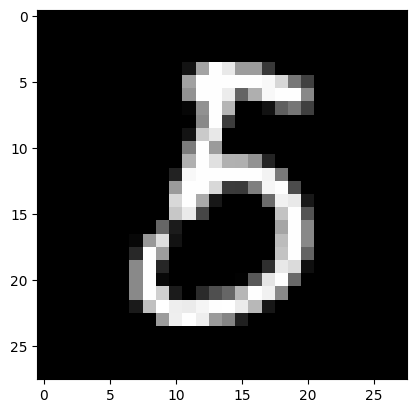

Prediction:  [8]
Label:  8


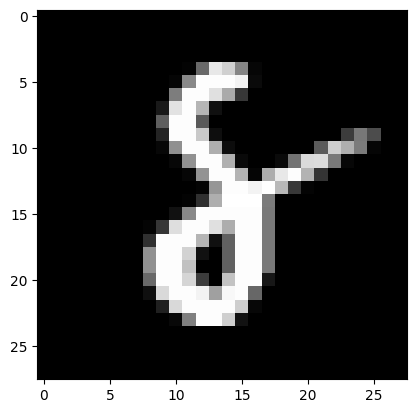

Prediction:  [8]
Label:  8


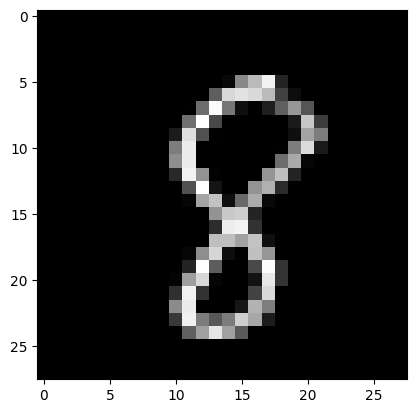

Prediction:  [1]
Label:  1


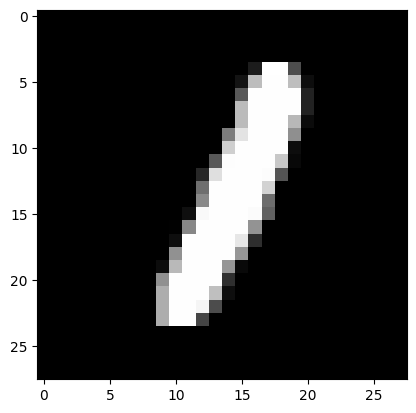

In [18]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [19]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[4 0 5 8 4 8 8 1 8 7 7 1 4 0 1 1 3 8 0 8 7 5 5 7 6 3 5 2 9 1 3 2 3 6 2 6 6
 1 1 2 7 3 3 7 6 9 8 5 9 3 1 2 0 4 6 4 7 9 6 1 4 9 6 2 8 4 8 1 2 3 6 4 5 0
 4 2 4 2 9 3 5 1 0 4 2 8 1 5 8 0 8 8 7 6 1 7 9 3 4 8 5 3 6 4 3 5 0 6 7 9 6
 1 2 1 0 1 9 8 7 0 8 4 4 3 3 2 1 0 1 8 3 8 9 7 1 0 6 3 3 5 3 0 7 8 3 1 4 5
 6 9 5 6 1 9 3 7 7 7 5 9 6 7 3 6 1 7 1 1 5 9 6 7 8 7 7 3 4 1 6 0 1 9 0 3 2
 2 1 1 2 5 4 2 0 0 2 4 8 1 0 3 9 7 3 2 5 8 9 0 6 2 8 2 7 7 2 8 9 3 4 4 7 6
 0 6 9 8 3 8 3 9 3 0 2 8 5 2 7 5 2 8 6 4 1 4 5 4 4 0 0 8 0 8 2 9 1 8 6 7 9
 0 0 7 9 4 9 1 8 3 3 2 1 5 9 9 3 1 6 0 5 6 2 6 0 8 6 8 7 0 6 6 5 7 0 6 6 2
 6 2 6 7 1 5 2 3 9 0 6 3 2 1 7 4 7 2 8 7 8 5 1 4 0 7 3 1 4 7 4 9 8 9 5 5 0
 1 1 1 6 3 1 7 6 4 1 7 7 9 8 8 1 2 2 9 2 3 8 2 4 4 0 6 0 2 2 0 6 1 0 9 8 3
 1 7 1 6 7 8 7 9 4 0 0 8 7 7 0 8 7 6 7 9 3 2 9 6 4 3 3 4 8 1 1 3 7 6 9 3 1
 3 6 1 9 4 0 5 1 4 6 5 5 7 8 9 7 6 1 5 0 4 1 2 2 1 3 1 8 7 0 8 1 0 8 5 7 1
 7 9 0 3 1 5 0 0 6 9 9 0 3 8 3 1 2 9 4 1 5 7 1 0 5 4 0 4 9 7 3 0 9 7 8 7 7
 0 3 5 9 4 2 7 6 9 6 7 3 

np.float64(0.85)

Still 84% accuracy, so our model generalized from the training data pretty well.